<a href="https://colab.research.google.com/github/azmiak/Kuliah-Deep-Learning/blob/main/Week%205%20/%20Tugas%20/%20PyTorch_ReviewTokoBaju_RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RNN

In [22]:
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences

In [23]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
df = pd.read_csv("ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()

# Text preprocessing
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['Review Text']).toarray()
X = pad_sequences(X, maxlen=300, padding='post')

# Labels
y = df['Recommended IND'].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
x_train, x_test = torch.tensor(x_train, dtype=torch.long), torch.tensor(x_test, dtype=torch.long)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [11]:
# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = ReviewDataset(x_train, y_train)
test_dataset = ReviewDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# RNN model definition
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.dropout(self.relu(self.fc1(out)))
        out = torch.sigmoid(self.fc2(out))
        return out

In [15]:
# Model setup
model = RNNModel(vocab_size=5000, embed_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []

for epoch in range(20):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x).squeeze()
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).int()
        train_correct += (preds == y.int()).sum().item()
        train_total += y.size(0)

    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x).squeeze()
            loss = criterion(outputs, y)
            test_loss += loss.item()

            probs = outputs.detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.extend(preds)
            all_scores.extend(probs)
            all_labels.extend(y.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/20] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")

Epoch [1/20] Train Acc: 0.8159, Train Loss: 0.4810 | Test Acc: 0.8207, Test Loss: 0.4770
Epoch [2/20] Train Acc: 0.8184, Train Loss: 0.4774 | Test Acc: 0.8207, Test Loss: 0.4723
Epoch [3/20] Train Acc: 0.8184, Train Loss: 0.4798 | Test Acc: 0.8207, Test Loss: 0.4723
Epoch [4/20] Train Acc: 0.8184, Train Loss: 0.4791 | Test Acc: 0.8207, Test Loss: 0.4707
Epoch [5/20] Train Acc: 0.8184, Train Loss: 0.4792 | Test Acc: 0.8207, Test Loss: 0.4706
Epoch [6/20] Train Acc: 0.8184, Train Loss: 0.4779 | Test Acc: 0.8207, Test Loss: 0.4723
Epoch [7/20] Train Acc: 0.8184, Train Loss: 0.4767 | Test Acc: 0.8207, Test Loss: 0.4749
Epoch [8/20] Train Acc: 0.8184, Train Loss: 0.4786 | Test Acc: 0.8207, Test Loss: 0.4724
Epoch [9/20] Train Acc: 0.8184, Train Loss: 0.4784 | Test Acc: 0.8207, Test Loss: 0.4729
Epoch [10/20] Train Acc: 0.8184, Train Loss: 0.4773 | Test Acc: 0.8207, Test Loss: 0.4707
Epoch [11/20] Train Acc: 0.8184, Train Loss: 0.4776 | Test Acc: 0.8207, Test Loss: 0.4708
Epoch [12/20] Train

Final Training Accuracy: 0.8184
Final Testing Accuracy: 0.8207
Precision: 0.8207
Recall: 1.0000
F1 Squared: 0.8128
AUC: 0.4945


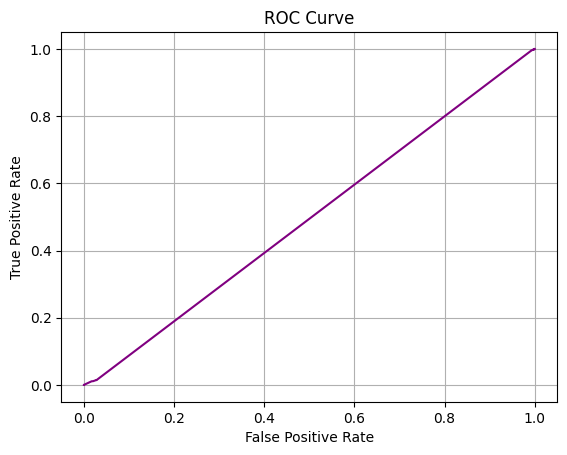

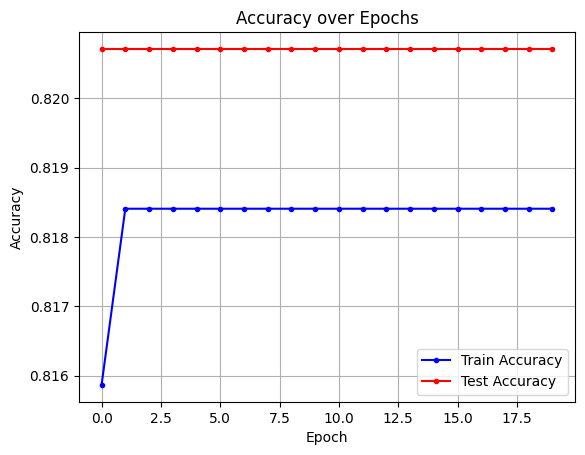

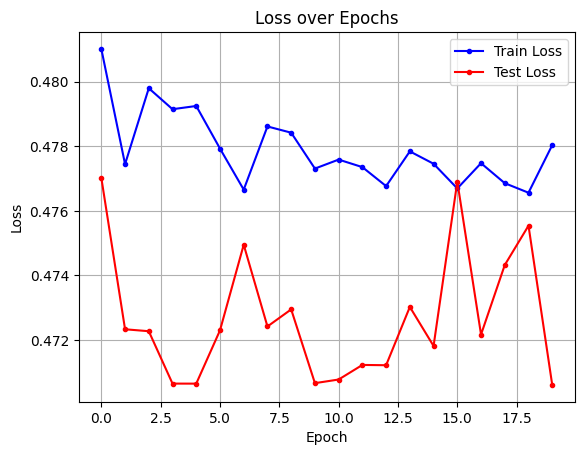

In [21]:
# Evaluation
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1_sq = f1_score(all_labels, all_preds)**2
auc = roc_auc_score(all_labels, all_scores)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve', color='purple')
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

# Accuracy graph
plt.figure()
plt.plot(train_acc_list, label="Train Accuracy", color='blue', marker='.')
plt.plot(test_acc_list, label="Test Accuracy", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure()
plt.plot(train_loss_list, label="Train Loss", color='blue', marker='.')
plt.plot(test_loss_list, label="Test Loss", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

#LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
df = pd.read_csv("ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="")
tokenizer.fit_on_texts(df['Review Text'])
X = tokenizer.texts_to_sequences(df['Review Text'])
X = pad_sequences(X, maxlen=300, padding='post')

# Labels
y = df['Recommended IND'].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
x_train, x_test = torch.tensor(x_train, dtype=torch.long), torch.tensor(x_test, dtype=torch.long)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [6]:
# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Build Dataset & DataLoader
train_dataset = ReviewDataset(x_train, y_train)
test_dataset = ReviewDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# LSTM model definition
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        _, (h_n, _) = self.lstm(embedded)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = self.dropout(torch.relu(self.fc1(h_n)))
        x = self.sigmoid(self.fc2(x))
        return x.view(-1)

In [11]:
# Model setup
vocab_size = len(tokenizer.word_index) + 1
model = LSTMModel(vocab_size, embedding_dim=128, hidden_dim=128, output_dim=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []

for epoch in range(20):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    # Testing
    model.eval()
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            preds = (outputs >= 0.5).float()
            test_correct += (preds == y_batch).sum().item()

    test_acc = test_correct / len(test_dataset)
    test_loss_list.append(test_loss / len(test_loader))
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/20] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")

Epoch [1/20] Train Acc: 0.8212, Train Loss: 0.4057 | Test Acc: 0.8404, Test Loss: 0.3603
Epoch [2/20] Train Acc: 0.8548, Train Loss: 0.3314 | Test Acc: 0.8560, Test Loss: 0.2959
Epoch [3/20] Train Acc: 0.8849, Train Loss: 0.2677 | Test Acc: 0.8814, Test Loss: 0.2623
Epoch [4/20] Train Acc: 0.9016, Train Loss: 0.2437 | Test Acc: 0.8691, Test Loss: 0.6572
Epoch [5/20] Train Acc: 0.8917, Train Loss: 0.2851 | Test Acc: 0.8735, Test Loss: 0.2969
Epoch [6/20] Train Acc: 0.9181, Train Loss: 0.2033 | Test Acc: 0.8887, Test Loss: 0.3068
Epoch [7/20] Train Acc: 0.9344, Train Loss: 0.1719 | Test Acc: 0.8927, Test Loss: 0.2859
Epoch [8/20] Train Acc: 0.9457, Train Loss: 0.1443 | Test Acc: 0.8936, Test Loss: 0.2777
Epoch [9/20] Train Acc: 0.9523, Train Loss: 0.1317 | Test Acc: 0.8841, Test Loss: 0.3020
Epoch [10/20] Train Acc: 0.9634, Train Loss: 0.1030 | Test Acc: 0.8934, Test Loss: 0.3404
Epoch [11/20] Train Acc: 0.9694, Train Loss: 0.0873 | Test Acc: 0.8889, Test Loss: 0.3541
Epoch [12/20] Train

Final Training Accuracy: 0.9919
Final Testing Accuracy: 0.8755
Precision: 0.9342
Recall: 0.9126
F1 Squared: 0.8524
AUC: 0.9045


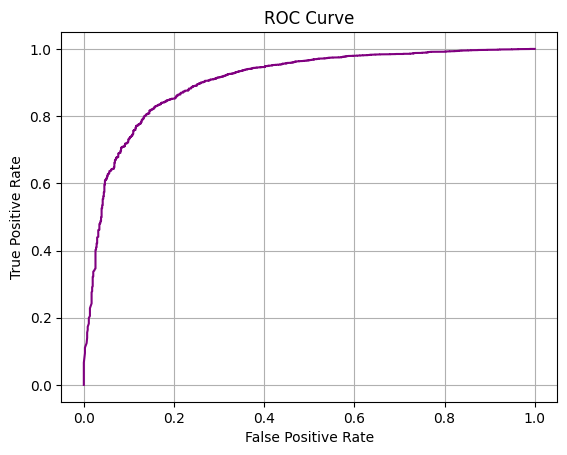

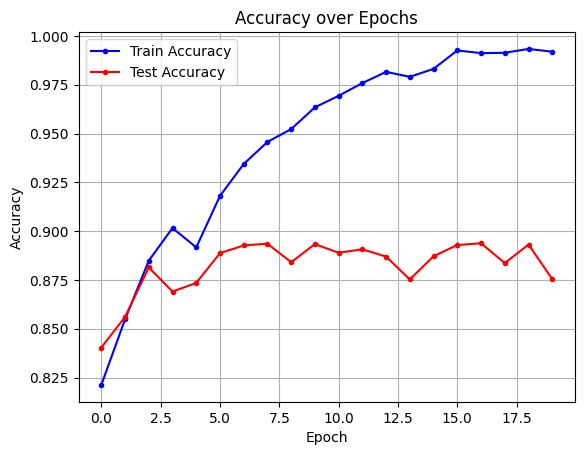

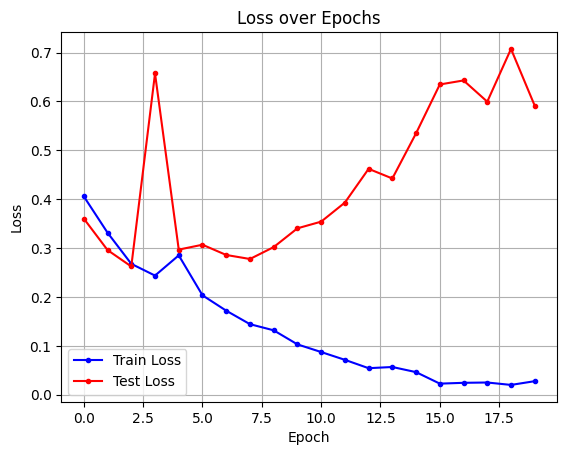

In [13]:
# Evaluation
model.eval()
y_probs = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        y_probs.extend(outputs.cpu().numpy())

y_probs = np.array(y_probs)
y_preds = (y_probs >= 0.5).astype(int)

precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1_sq = f1_score(y_test, y_preds) ** 2
auc = roc_auc_score(y_test, y_probs)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve', color='purple')
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

# Accuracy graph
plt.figure()
plt.plot(train_acc_list, label="Train Accuracy", color='blue', marker='.')
plt.plot(test_acc_list, label="Test Accuracy", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure()
plt.plot(train_loss_list, label="Train Loss", color='blue', marker='.')
plt.plot(test_loss_list, label="Test Loss", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

#GRU

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
df = pd.read_csv("ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="")
tokenizer.fit_on_texts(df['Review Text'])
X = tokenizer.texts_to_sequences(df['Review Text'])
X = pad_sequences(X, maxlen=300, padding='post')

# Labels
y = df['Recommended IND'].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
x_train, x_test = torch.tensor(x_train, dtype=torch.long), torch.tensor(x_test, dtype=torch.long)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [18]:
# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Build Dataset & DataLoader
train_dataset = ReviewDataset(x_train, y_train)
test_dataset = ReviewDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# GRU model definition
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        _, h_n = self.gru(embedded)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = self.dropout(torch.relu(self.fc1(h_n)))
        x = self.sigmoid(self.fc2(x))
        return x.view(-1)

In [19]:
# Model setup
vocab_size = len(tokenizer.word_index) + 1
model = GRUModel(vocab_size, embedding_dim=128, hidden_dim=128, output_dim=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []

for epoch in range(20):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    # Testing
    model.eval()
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            preds = (outputs >= 0.5).float()
            test_correct += (preds == y_batch).sum().item()

    test_acc = test_correct / len(test_dataset)
    test_loss_list.append(test_loss / len(test_loader))
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/20] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")

Epoch [1/20] Train Acc: 0.8207, Train Loss: 0.4321 | Test Acc: 0.8401, Test Loss: 0.3790
Epoch [2/20] Train Acc: 0.8499, Train Loss: 0.3418 | Test Acc: 0.8675, Test Loss: 0.2955
Epoch [3/20] Train Acc: 0.8856, Train Loss: 0.2602 | Test Acc: 0.8847, Test Loss: 0.2998
Epoch [4/20] Train Acc: 0.9118, Train Loss: 0.2128 | Test Acc: 0.8858, Test Loss: 0.2772
Epoch [5/20] Train Acc: 0.9286, Train Loss: 0.1767 | Test Acc: 0.8958, Test Loss: 0.2595
Epoch [6/20] Train Acc: 0.9435, Train Loss: 0.1452 | Test Acc: 0.8907, Test Loss: 0.2832
Epoch [7/20] Train Acc: 0.9546, Train Loss: 0.1153 | Test Acc: 0.8934, Test Loss: 0.2926
Epoch [8/20] Train Acc: 0.9671, Train Loss: 0.0885 | Test Acc: 0.8865, Test Loss: 0.3573
Epoch [9/20] Train Acc: 0.9790, Train Loss: 0.0577 | Test Acc: 0.8770, Test Loss: 0.4555
Epoch [10/20] Train Acc: 0.9853, Train Loss: 0.0432 | Test Acc: 0.8814, Test Loss: 0.4942
Epoch [11/20] Train Acc: 0.9859, Train Loss: 0.0432 | Test Acc: 0.8865, Test Loss: 0.5500
Epoch [12/20] Train

Final Training Accuracy: 0.9980
Final Testing Accuracy: 0.8898
Precision: 0.9245
Recall: 0.9427
F1 Squared: 0.8715
AUC: 0.9187


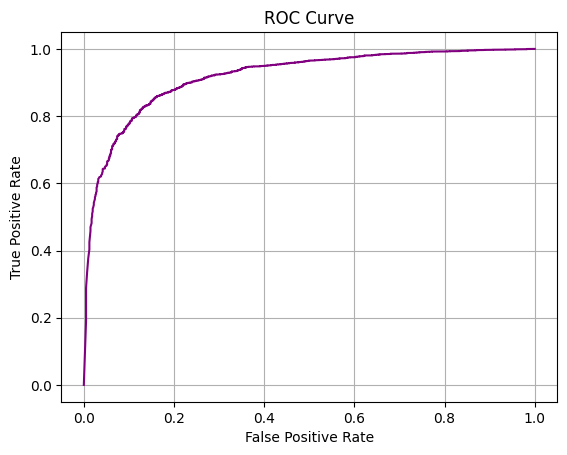

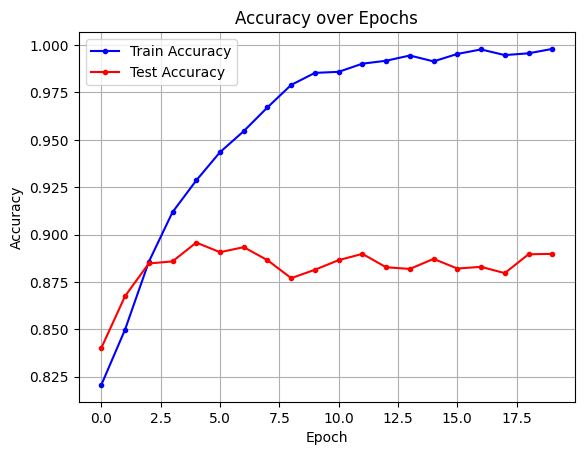

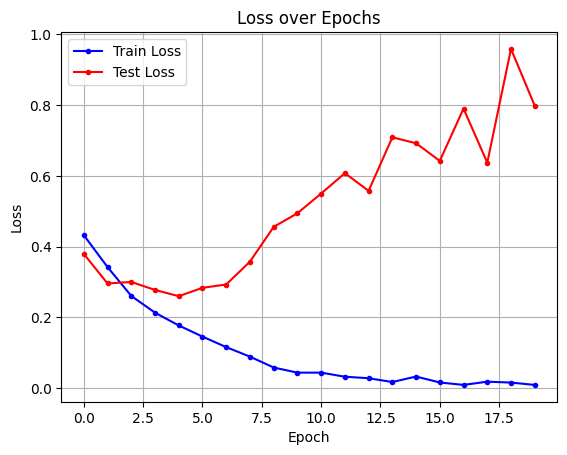

In [20]:
# Evaluation
model.eval()
y_probs = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        y_probs.extend(outputs.cpu().numpy())

y_probs = np.array(y_probs)
y_preds = (y_probs >= 0.5).astype(int)

precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1_sq = f1_score(y_test, y_preds) ** 2
auc = roc_auc_score(y_test, y_probs)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve', color='purple')
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

# Accuracy graph
plt.figure()
plt.plot(train_acc_list, label="Train Accuracy", color='blue', marker='.')
plt.plot(test_acc_list, label="Test Accuracy", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure()
plt.plot(train_loss_list, label="Train Loss", color='blue', marker='.')
plt.plot(test_loss_list, label="Test Loss", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

#Persamaan Matematika pada DL

---

##1. RNN
RNN memproses urutan data dengan mempertahankan hidden state dari langkah sebelumnya. Persamaan matematikanya:

$h_t = \tanh(W_h h_{t-1} + W_x x_t + b)$

---

##2. LSTM
LSTM menggunakan tiga gate utama: forget gate, input gate, dan output gate, serta sebuah cell state yang menyimpan memori jangka panjang.

$f_t = \sigma(W_fx_t + U_fh_{t-1} + b_f)$ (forget gate)

$i_t = \sigma(W_i [h_{t-1}, x_t] + b_i)$ ,
$\tilde{C}_t = \tanh(W_C [h_{t-1}, x_t] + b_C)$ (input gate)

$C_t = f_t . C_{t-1} + i_t . \tilde{C}_t$ (update cell state)

$o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o)$ (quad output gate)

$h_t = o_t . \tanh(C_t)$ (hidden state)

---

##3. GRU
